# Supervised behaviors in DeepOF - using predefined behaviors

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lucasmiranda42/deepof/blob/master/docs/source/tutorial_notebooks/deepof_supervised_tutorial.ipynb)

##### What we'll cover:
    
* Which behaviors are detected during supervised annotations
* How are these behaviors defined
* How do detected behaviors look in practise
* What are the limitations of the supervised behaviors

In [1]:
# # If using Google colab, uncomment and run this cell and the one below to set up the environment
# # Note: because of how colab handles the installation of local packages, this cell will kill your runtime.
# # This is not an error! Just continue with the cells below.
# import os
# !git clone -q https://github.com/mlfpm/deepof.git
# !pip install -q -e deepof --progress-bar off
# os.chdir("deepof")
# !curl --output tutorial_files.zip https://datashare.mpcdf.mpg.de/s/4J9fApqfNaoBsq6/download
# !unzip tutorial_files.zip

In [2]:
# import os
# os.chdir("deepof")
# import os, warnings
# warnings.filterwarnings('ignore')

The main focus on this tutorial is on explaining the supervised behaviors. For this we will first use some functionality that is explained in more detail in the supervised tutorial to create a Gantt plot. Respectively, if you want to learn more about what deepof can do in terms of the visualization of these behaviors, you can have a look at the [supervised tutorial](https://deepof.readthedocs.io/en/latest/tutorial_notebooks/deepof_supervised_tutorial.html).

### Behavior overview

Anyways, as usual we will first import some packages:

In [3]:
import os
import deepof.data
from matplotlib import pyplot as plt

Then load an existing project

In [4]:
# Load a previously saved project
my_deepof_project = deepof.data.load_project("./tutorial_files/tutorial_project")

Calculate the supervised annotations

In [5]:
supervised_annotation = my_deepof_project.supervised_annotation()

supervised annotations        : 100%|██████████| 53/53 [01:06<00:00,  1.25s/table, step=post processing]   


And create an initial Gantt plot as an overview for one of the videos (20191204_Day2_SI_JB08_Test_54) in this batch of supervised_annotations

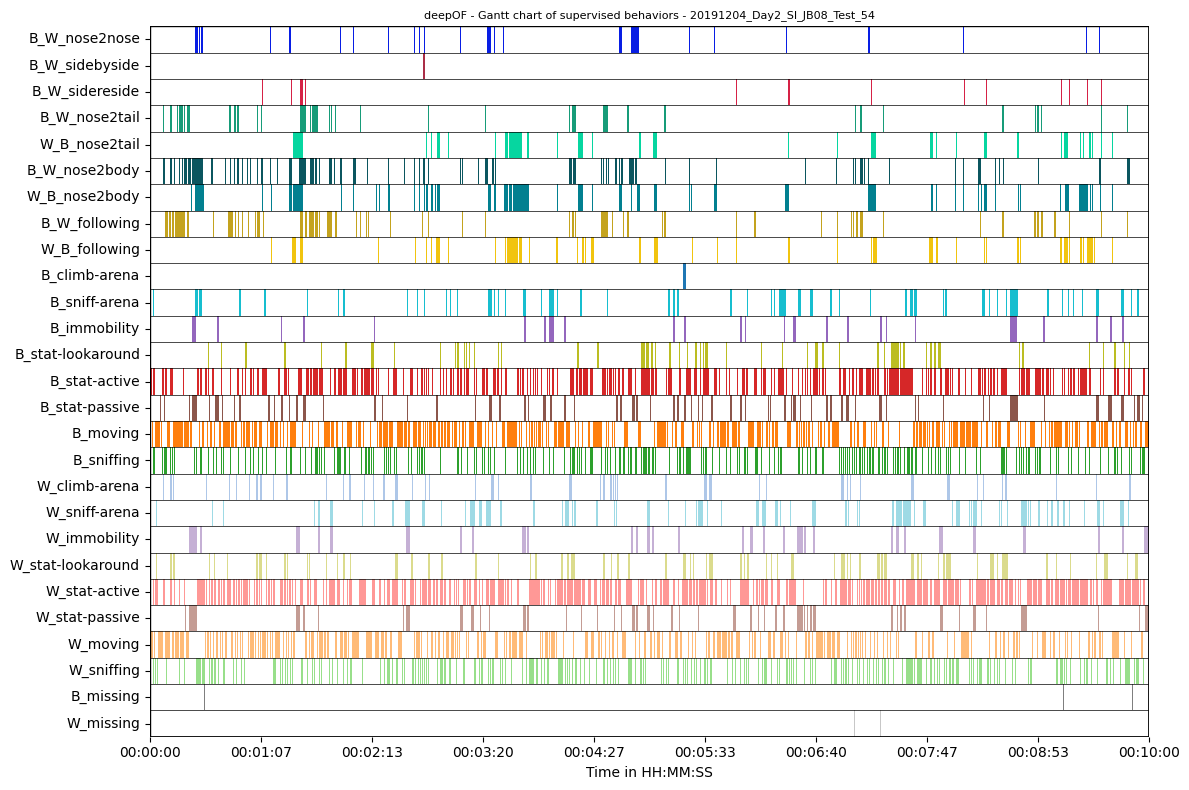

In [6]:
plt.figure(figsize=(12, 8))

deepof.visuals.plot_gantt(
    my_deepof_project,
    "20191204_Day2_SI_JB08_Test_54",
    supervised_annotations=supervised_annotation,
)

plt.show()

As we can see in the plot, there are quite a lot of predefined behaviors (named on the left side of the plot) that deepof detects. In general, there are two types of behaviors: Single-mouse and paired-mouse behaviors. For each frame of the video, the presence or absence of each behavior is detected. The colored bars indicate the presence of a behavior, white background indicates its absence.

In the given video we have two mice, a white and a black one, respectively indicated by "W" and "B". A single mouse behavior like e.g. "moving" is measured for each mouse individually. Respectively "B_moving" indicates that the black mouse is moving, "W_moving" indicates that the white mouse is moving. 

Analogously paired behaviors have indicators for both involved mice. "B_W_nose2nose" indicates that there is nose-nose contact between teh black and the white mouse. Some of the paired behaviors are additionally directional, like "following". Since it matters which mouse follows which, there are two versions of this behavior. "B_W_following" indicates that the black mouse follows the white one and respectively "W_B_following" indictaes that the white mouse is following the black one.

Most behaviors can be modulated with different supervised parameters. These parameters are

In [7]:
params=my_deepof_project.get_supervised_parameters()
params

{'close_contact_tol': 25,
 'side_contact_tol': 50,
 'median_filter_width': 12,
 'follow_frames': 12,
 'min_follow_frames': 6,
 'follow_tol': 25,
 'climb_tol': 0.15,
 'sniff_arena_tol': 12.5,
 'min_immobility': 24,
 'stationary_threshold': 40,
 'nose_likelihood': 0.85}

What they represent will be explained during the explanation of the behaviors.

### Single mouse behaviors

Currently, deepof features nine different single-mouse behaviors: 

* climb_arena
* sniff_arena
* immobility
* stat_lookaround
* stat_active 
* stat_passive
* moving
* sniffing
* missing

#### Climb_arena

**The climb_arena behavior is measuring if a mouse inside of the arena is trying to climb it.** This is done by measuring if the nose the mouse is more than a given value beyond the edge of the arena (the one that you can either auto-detect or mark manually during project creation). It is calculated as follows:

- For each frame: Get an estimation of the body lenght of the mouse (without tail) by summing up the distances between all (available) backbone bodyparts 

["Nose", "Spine_1", "Center", "Spine_2", "Tailbase"]
- Take the 80% percentile of these distances as a length estimation
- Calculate tol = mouse length * ***params["climb_tol"]***
- For each frame: interpolate nans in mouse Nose positions linearly
- For each frame: Check if the nose o the mouse is further outside of the arena border (the line that is drawn during project creation) than tol
- Median filter the resulting binary array with filter width ***params["median_filter_width"]***


![W_climb_arena](./Assets/Behaviors/W_climb_arena.gif)

The video above shows one instance of detected climbing behavior for the white mouse. Note how the behavior is only triggered once, as the second time the white mouse looks up (around 8:37) its nose is not far enough outside of the bounds of the arena.

#### Sniff_arena

**The sniff_arena behavior is measuring if a mouse inside of the arena is sniffing the arena edge.** This is done by first determining if the mouse is currently relatively immobile, then secondly measuring if the nose the mouse is closer than a threshold to the edge of the arena (the one that you can either auto-detect or mark manually during project creation). It is calculated as follows:


- For each frame: Check if the nose of the mouse is closer than ***params["sniff_arena_tol"]*** to the arena edge
- For each frame: Check if the speed of the center the mouse (e.g. bodypart "Center" in deepof_14) is smaller than ***params["stationary_threshold"]*** 
- If both conditions are fulfilled, the frame is counted as arena sniffing
- Median filter the resulting boolean array with filter width ***params["median_filter_width"]***


![B_sniff_arena](./Assets/Behaviors/B_sniff_arena.gif)

The video above shows multiple instances of detected arena sniffing behavior for the black mouse. Note how the behavior is still triggered at 9:20 despite short climbing attempt of the black mouse. This is due to a short tracking error (black mosue in front of black arena) that detects the nose lower than it actually is. Always keep in mind that deepof is not working with the videos directly but with the tracked data. Respectively make sure to properly track your mosues, as errors in tracking can translate to errors in behavior detection.

#### Immobility

**The immobility behavior is measuring if a mouse stops moving for at least 1 second (default).** This is done by applying a XGBoost classifier and some post processing steps. It is calculated as follows:


- Check if all main body bodyparts of the mouse are detected (labelling schema deepof_11 or deepof_14 is used)
- Save indices of all frames in which more than 10% of the data are nans
- Impute missing data
- Apply immobility classifier

[Labelling criteria for classifier: Mouse stops whatever it is doing suddenly, like it's frozen in place. State needs to persist for min. 0.5 seconds]

- Set corresponding entries of the resulting boolean array for all frames that previously had more than 10% Nans to 0
- Median filter the resulting boolean array with filter width ***params["median_filter_width"]***
- Remove all segments of 1s of the resulting boolean array that are shorter than ***params["min_immobility"]***

![B_immobility](./Assets/Behaviors/B_immobility.gif)

As shown in the video above, the black mouse is labeled with "immobility" when it stops and stays relatively motionless for a short while. 

#### Stat_lookaround

**The stat_lookaround behavior is measuring if a mouse stands still and is looking around.** This is done by determining frames of relative immobility, then detrmining in which of these frames the mouse is moving its nose, has a relatively normal frontal head tilt and is not too close with its nose to anotehr mouse, if there are any. It is calculated as follows:


- Save indices of all frames with undefined center speed
- Interpolate missing center speeds linearily
- Get "immobile" frames:

    - Detect all frames with Tail base speed <= 2* ***params["stationary_threshold"]*** and save as a binary array
    - Moving average filter this array with a window length of ***params["min_follow_frames"]***
    - Remove all segments of 1s in the resulting boolean array that are shorter than ***params["min_follow_frames"]***

- Get "nose_activity" frames:

    - Detect all frames in which Nose speed > ***params["stationary_threshold"]***
    - And in which additionally nose likelihood > ***params["nose_likelihood"]***

- Get "lower_body_inactivity" frames:

    - Detect all frames for which speed of ["Left_bhip", "Right_bhip"] =< 2* ***params["stationary_threshold"]*** and likelihood > ***params["nose_likelihood"]***

- Get "head_orientation" frames:

    - For all frames: Get the distance between the nose and the left ear and the nose and the right ear of the mouse
    - Determine all distances that are larger than 0.9 * the median distance for both distance types (Nose-Left_ear and Nose-Right_ear)
    - Determine all frames in which the above is true for both distance types

- Get "not_close_range" frames:

    - Determine all frames in which the nose of the mouse is farther away than ***params["side_contact_tol"]*** to any other mouse (if there are any) 

- For each frame: raw_lookaround = "immobile" and "nose_activity" and "lower_body_inactivity" and "head_orientation" and "not_close_range"
- For each frame: nonlookaround = immobile is true and the other conditions are False
- Apply multi_step_paired_smoothing on both
- Set all frames with previously undefined center speed in raw_lookaround to False
- stationary_lookaround = raw_lookaround

![B_stat_lookaround](./Assets/Behaviors/B_stat_lookaround.gif)

The video above shows two instances of detected stationary lookaround behavior for the black mouse. Note how the behavior does not require the mouse to stand on its hind legs. It is just a combination of active nose movement and some conditions (like a lowered head) that get excluded.

#### Stat_active, Stat_passive and Moving

**The stat_active and stat_passive behaviors are measuring if the mouse is standing still and either actively doing something or not. Moving covers (almost) all remaining frames in which the mouse is moving** These three behaviors are exclusive, meaning that the mouse can only ever be in one of these three states. First frames of relative immobility are determined, then these frames are subdivided via bodypart movement in active and passive instances. Only frames with undefined center speeds are excluded. It is calculated as follows:


- Save indices of all frames with undefined center speed
- Interpolate missing center speeds linearily
- Get "immobile" frames:

    - Detect all frames with center speed <= 2* ***params["stationary_threshold"]*** and save as a binary array
    - Moving average filter this array with a window length of ***params["min_follow_frames"]***
    - Remove all segments of 1s in the resulting boolean array that are shorter than ***params["min_follow_frames"]***

- Get "activity" frames:

    - Detect all frames for which the speed of any of 
    
    ["Nose", "Left_fhip", "Right_fhip", "Left_bhip", "Right_bhip"] 
    
    is greater than ***params["stationary_threshold"]***
    
    - And in which additionally the respective bodypart likelihood > ***params["nose_likelihood"]***

- For each frame: raw_stat_active = "immobile" and "activity"
- For each frame: raw_stat_passive = "immobile" and not "activity"
- Apply multi_step_paired_smoothing on both
- raw_mobile = not raw_stat_active and not raw_stat_passive
- Set all frames with previously undefined center speed in raw_stat_active, raw_stat_passive and raw_mobile to False
- stat_active = raw_stat_active, stat_passive = raw_stat_passive, mobile = raw_mobile

![B_stat_passive](./Assets/Behaviors/B_stat_passive.gif)

The video above shows the alternating three behaviors for the black mouse. As almost always one of the three states applies (except for frames with tracking errors in which it cannot be determined if the mouse if moving or not) this can result in occasional fast fluctuations between states. Further, as all behaviors only the skeleton data of teh mouse is used. This means if the mouse is just standing standing in a way that the skeleton does not move significantly but is still doing "something" (like sniffing the ground) respective frames will still be labeled as stat_passive. 

#### Sniffing

**The sniffing behavior is measuring if a mouse is stationary and moving its nose.** This behavior is a slightly modified version of the previous implementation of lookaround and relatively simplistic. It is calculated as follows:


- For each frame:

    - Check if Center speed is < ***params["stationary_threshold"]***
    - Check if Nose speed > ***params["stationary_threshold"]***
    - Check if Nose likelihood > ***params["nose_likelihood"]*** (certainty of nose detection)

- A frame is labeled as lookaround if all of the above apply,
- No further filtering

![B_sniffing](./Assets/Behaviors/B_sniffing.gif)

The video above shows the black mouse sniffing around. This behavior is mostly implemented for legacy reasons and can give information about the general activity of the mouse. A slight fix now prevents excessive "sniffing" (or former "lookaround") detection in an edge case. 

#### Missing

**The missing "behavior" is measuring if the mouse could be detected.** This "behavior" only serves control purposes. It is calculated as follows:


- For each frame: Check if the median prediction confidence score of all bodyparts is less or equal than 0.5
- Set all frames for which this is the case to "missing"

![B_missing](./Assets/Behaviors/B_missing.gif)

As can be seen in the video above, the black mouse is briefly marked as "missing", since most of its bodyparts could not be accurately predicted whilst it was passing the white mouse.

### Paired Mouse Behaviors

Currently, deepof features six different paired-mouse behaviors: 

* nose2nose
* sidebyside
* sidereside
* nose2tail
* nose2body 
* following

The first three of which are non-directional, the remaining three are directional

#### Nose2nose

**The nose2nose behavior is measuring if the noses of both mice get closer than a threshold.** This is done by simply determining all nose-nose distances of two mice for all frames. It is calculated as follows:

- For each frame: Check if the noses of both mice are closer than ***params["close_contact_tol"]*** to each other
- Median filter the resulting boolean array with filter width ***params["median_filter_width"]***

![B_W_nose2nose](./Assets/Behaviors/B_W_nose2nose.gif)

The video above illustrates a brief nose2nose contact between the two mice. The default width of the median filter is 0.5 seconds (in frames). This means that with default settings events shorter than ca. 0.25 seconds (in frames) won't be detected.

#### Sidebyside

**The sidebyside behavior is measuring if two mice are aligned closely side by side.** This is done by determining the nose-nose and tailbase-tailbase distances of both mice for all frames. It is calculated as follows:


- For each frame: Check if the nose of mouse A is closer than ***params["side_contact_tol"]*** to the nose of mouse B AND the tail base of mouse A is closer than ***params["side_contact_tol"]*** to the tail base of mouse B
- Median filter the resulting boolean array with filter width ***params["median_filter_width"]***

The video above shows a short sidebyside contact between the two mice. As shown, the side-side contact does not need to be very long by default. The side_contact_tol parameter can be set seperately from close_contact_tol and is per default twice as wide (50 mm instead of 25 mm).  

![B_W_sidebyside](./Assets/Behaviors/B_W_sidebyside.gif)

#### Sidereside

**The sidereside behavior is measuring if two mice are aligned closely side by side, but in reverse.** This is done by determining the nose-tailbase distances of both mice for all frames. It is calculated as follows:


- For each frame: The nose of mouse A is closer than ***params["side_contact_tol"]*** to the tail base of mouse B AND the tail base of mouse A is closer than ***params["side_contact_tol"]*** to the nose of mouse B
- Median filter the resulting boolean array with filter width ***params["median_filter_width"]***

![B_W_sidereside](./Assets/Behaviors/B_W_sidereside.gif)

The video above shows a prolonged sidereside contact between the two mice. The detection already starts slightly before the nose of the black mouse fully reaches the tailbase of the white mouse, as it is at that point in time "close enough" to it to trigger the detection. 

#### Nose2tail

**The nose2tail behavior is measuring if the nose of one mosue is closer than a threshold to the tail base of another mouse.** This is done by simply determining all nose-tail_base distances of two mice for all frames. It is calculated as follows:

- For each frame: Check if the nose of mouse A is closer than ***params["close_contact_tol"]*** to the tail base of mouse B
- Median filter the resulting boolean array with filter width ***params["median_filter_width"]***

![B_W_nose2tail](./Assets/Behaviors/B_W_nose2tail.gif)

The video above illustrates multiple B_W_nose2tail contacts between the black and the white mouse. Note that nose2tail is specifically measuring the distance between nose and tail base and not all of the tail (the behavior does not trigger at e.g. 4:36 when then nose of the black mouse is close to the tail (but not the tail base) of the white mouse). Further this behavior is directional, which means that the order of the animal ids denots which mouse sniffs on whichs tail base.

#### Nose2body

**The nose2body behavior is measuring if the nose of one mosue is closer than a threshold to any body part of another mouse.** This is done by simply determining all nose-body part distances of two mice for all frames. It is calculated as follows:

- For each frame: Check if the nose of mouse A is closer than ***params["close_contact_tol"]*** to any body part of mouse B
- Median filter the resulting boolean array with filter width ***params["median_filter_width"]***

![B_W_nose2body](./Assets/Behaviors/B_W_nose2body.gif)

In the video above it can be seen how the black mouse first approaches the white mouse from behind, then has an extended nose2nose interaction with it. Both instances trigger the nose2body behavior detection. This behavior is directional.

#### Following

**The following behavior is determining if one mouse is following another mouse.** This is done by determining the distances between nose and tail base of two mice over multiple frames in teh past. I.e. is the Nose of mouse A close to the position where the tail base of mouse B has been a few frames before for multiple frames?


- For each Frame: 
    - Calculate distances between the nose of mouse A and the tail base of mouse B for up to ***params["follow_frames"]*** delay (i.e. how close is the nose of mouse A to the tail base of mouse B at the current frame and up to ***params["follow_frames"]*** in the past)
    - This results in an array of length ***params["follow_frames"]*** containing distances from the tail base of mouse B to the current and past nose positions of mouse A
    - Check if the distance between the nose of mouse A and the tailbase of mouse B is smaller than the distance between the noses or tail bases of both mice (i.e. are the animals oriented the right way)
    - A frame is labeled as A_B_following if all of the following (pun not intended) apply:

        - The shortest nose-tailbase distance in the array for this frame is smaller than ***params["follow_tol"]***
        - The mice are oriented the right way
        - The speed of the mice is > ***params["stationary_threshold"]***

- Median filter the resulting boolean array with filter width ***params["median_filter_width"]***
- Remove all instances of following that are shorter than ***params["min_follow_frames"]***

![B_W_following](./Assets/Behaviors/B_W_following.gif)

In the video above the black mouse is following the white mouse along the arena. As one can see, the detection of following stops when either the black mouse stops (0:14) or it's nose deviates too much from the path the tail base of the white mosue has taken (0:19). Unsurprisingly, this behavior is directional.

### Limitations and Trouble Shooting

One of the very first steps in conducting valid science is to actually understand the tools one is working with. In this sense, congratulations for reading this tutorial. Because fully automatized behavior detection can never be perfect and there might be setups where certain things work better and other things work worse, we offer various tools to inspect detected behaviors and make it possible to adjust parameters. These tools are explained in our [Deepof utilities tutorial](https://deepof.readthedocs.io/en/latest/tutorial_notebooks/deepof_unsupervised_tutorial.html). To conclude this tutorial, let's list a few points to consider in this regard when working with supervised behaviors:

1. The supervised behaviors in deepof are all based on the tracked bodypart markers of the mice. This means that tracking errors can translate to errors in behavior detection. If there are minor issues with your tracked data (like missing markers in some frames etc.), deepof can deal with them automatically. However, if there are major issues that lead to the overall reliability of the tracked data being low, this will negatively affect the reliability of the detected behaviors.
2. The supervised behaviors in deepof are mostly based on traditional algorithms and they will detect exactly what is described in this tutorial. I.e. if you label the left hind-leg of a mouse as "nose", nose2nose interactions will respectively be detected when the left hind legs of the mice come close. The algorithms are designed to extract useful behaviors, but special cases that lead to unexpected detections may arise in your data. I.e. if you see something surprising, verify it by further investigation.
3. If you have questions that go beyond these tutorials, feel always free to contact us on githup and open an issue (https://github.com/mlfpm/deepof/issues). 

This was all for this tutorial. Have fun using DeepOF!